# Basketball Shot Behavior Analysis Based on the “Kobe Bryant Shot Selection” Dataset

## — A Spatiotemporal Sports Analytics Approach

### Author: Lu Zixuan @ Nov. 2025


This study uses the Kaggle dataset “Kobe Bryant Shot Selection” (https://www.kaggle.com/c/kobe-bryant-shot-selection). The dataset contains approximately 30,000 shot records from the 1996–2016 seasons, including variables such as location coordinates, distance, time, shot type, game phase, opponent, and playoff status.


## Preparation: Check Environment


In [1]:
import importlib.util
import subprocess
import importlib
import sys


# List of libraries that need to be checked
required_libraries = [
    "pandas",
    "matplotlib",
    "seaborn",
    "IProgress",
    "libpysal",
    "esda",
    "pygam",
    "shap",
    "scipy"
]

# Function to check if a library is installed
def is_installed(library):
    # Check if the library specification can be found
    return importlib.util.find_spec(library) is not None

# Check all required libraries and collect missing ones
missing_libraries = [lib for lib in required_libraries if not is_installed(lib)]

# Display results
if not missing_libraries:
    print("All required libraries are properly installed!")
else:
    print("The following libraries are not installed:")
    for lib in missing_libraries:
        print(f"- {lib}")
    
    # Generate installation command
    install_command = f"pip install {' '.join(missing_libraries)}"
    print(f"\nIt is recommended to install the missing libraries using:")
    print(install_command)
    
    # Alternative command suggestion
    print(f"If the above command fails, you can try:")
    print(f"pip3 install {' '.join(missing_libraries)}")
    

All required libraries are properly installed!


In [2]:
print("Installed library versions:")
print("---------------------------")

for lib in required_libraries:
    try:
        # Deal with special case of IProgress, which may be imported differently
        if lib == "IProgress":
            # Try to import from ipywidgets
            from ipywidgets import IntProgress
            print(f"IProgress (from ipywidgets): {importlib.import_module('ipywidgets').__version__}")
        else:
            module = importlib.import_module(lib)
            if hasattr(module, '__version__'):
                print(f"{lib}: {module.__version__}")
            else:
                print(f"{lib}: Version information not found")
    except ImportError:
        # If import fails, try to check if it's installed via pip
        try:
            result = subprocess.check_output(
                [sys.executable, "-m", "pip", "show", lib.lower()],
                stderr=subprocess.STDOUT,
                text=True
            )
            for line in result.splitlines():
                if line.startswith("Version:"):
                    print(f"{lib}: {line.split(': ')[1]}")
                    break
            else:
                print(f"{lib}: Installed but version information not found")
        except subprocess.CalledProcessError:
            print(f"{lib}: Not installed")


Installed library versions:
---------------------------
pandas: 2.2.3
matplotlib: 3.10.3
seaborn: 0.13.2
IProgress: 0.4
libpysal: 4.13.0
esda: 2.8.0


c:\Users\fh\.conda\envs\da312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


pygam: 0.10.1
shap: 0.49.1
scipy: 1.15.3


## Target 1: Data Preprocessing and Feature Engineering

Check existing data, remove redundant data and empty data.

Data Preprocessing and Feature Engineering: Remove missing or duplicate records, standardize time and coordinates, convert shot locations to polar coordinates, and create derived variables such as temporal (remaining time, quarter, overtime), spatial (distance, angular zones), contextual (home/away, playoff, score difference), and psychological pressure proxies (shots with <24 seconds remaining or when trailing). Normalize numeric features and one-hot encode categorical variables.


In [3]:
import pandas as pd

# Import data
filename= "data.csv"  # the original data file, define for whole project, modify if your data file is named differently
raw = pd.read_csv(filename)

# Remove null value of shot_made_flag
kobe =  raw[pd.notnull(raw['shot_made_flag'])]
print(kobe.shape)

(25697, 25)


Now we only have 25,697 data points for training.

Next, we analyze these 4 labels: lat, loc_x, loc_y, and lon. These 4 labels indicate the location of Kobe's shot. But what exactly do they refer to, and what is the relationship between them? Let's draw a scatter plot to take a look. The code is written as follows:


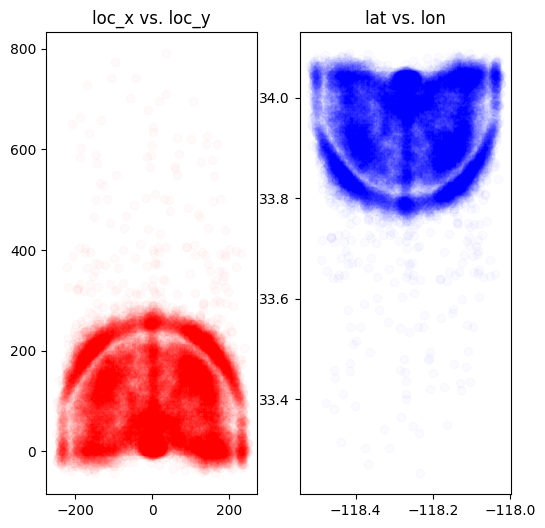

In [4]:
import pandas as pd
import matplotlib.pyplot as plt

# Create scatter plots to analyze the 4 features: lat, loc_x, loc_y, lon
alpha = 0.02  # Define a value for transparency setting later
plt.figure(figsize=(6, 6))  # Set the size of the plotting area

# Plot loc_x vs. loc_y
plt.subplot(121)  # 1 row, 2 columns, place plot in the 1st position
plt.scatter(kobe.loc_x, kobe.loc_y, color='red', alpha=alpha)  # Create scatter plot
plt.title('loc_x vs. loc_y')

# Plot lat vs. lon
plt.subplot(122)  # 1 row, 2 columns, place plot in the 2nd position
plt.scatter(kobe.lon, kobe.lat, color='blue', alpha=alpha)
plt.title('lat vs. lon')

plt.show()

We can roughly see that these 4 coordinates generally represent the distance from the basket. In that case, we can just choose one set of these data for subsequent data processing.
The four labels - shot_type, shot_zone_area, shot_zone_basic, and shot_zone_range - all represent the shooting area, essentially conveying the same information, so we won't elaborate on them here. Of course, compared with shot_type, the three labels shot_zone_area, shot_zone_basic, and shot_zone_range classify the shooting area more precisely. You might wonder if there will be any problems if we delete them directly, but there's actually no need to worry. This is because we will represent Kobe's shooting positions in the form of polar coordinates next, which will further refine Kobe's shooting areas.

First, we'll handle the polar coordinate issue mentioned in the previous section. Then we'll find that the calculated "dist" has a positive correlation with "shot_distance".


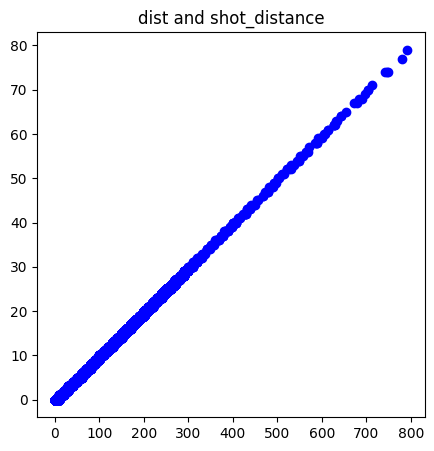

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
from sklearn.ensemble import RandomForestClassifier  # Import Random Forest classifier
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import log_loss

# Import data
# filename = "data.csv"
raw = pd.read_csv(filename)


# Remove entries where 'shot_made_flag' is empty, name the remaining data 'kobe' for training
kobe = raw[pd.notnull(raw['shot_made_flag'])]


# Among the 4 features (lat, loc_x, loc_y, lon), select loc_x and loc_y and convert them to polar coordinates
# 'dist' represents distance from the basket, 'angle' represents shooting angle; these better reflect Kobe's shooting results
raw['dist'] = np.sqrt(raw['loc_x']**2 + raw['loc_y']**2)
loc_x_zero = raw['loc_x'] == 0
# Initialize angle column safely and assign using .loc to avoid chained-assignment warnings
raw['angle'] = np.zeros(len(raw))
raw.loc[~loc_x_zero, 'angle'] = np.arctan(raw.loc[~loc_x_zero, 'loc_y'] / raw.loc[~loc_x_zero, 'loc_x'])
raw.loc[loc_x_zero, 'angle'] = np.pi / 2

# Plot to show the positive correlation between 'dist' and 'shot_distance'
plt.figure(figsize=(5,5))
plt.scatter(raw.dist, raw.shot_distance, color='blue')
plt.title('dist and shot_distance')
plt.show()

In this case, we can keep one of them (here we retain the "dist" label). Next, we will convert "minutes_remaining" and "seconds_remaining" into a single label "remaining_time", then delete unnecessary columns, and convert non-numeric types into one-hot encoding format.

The specific code is written as follows, with detailed explanations in the code comments:


In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Import data
# filename = "data.csv"
raw = pd.read_csv(filename)

# Remove entries where 'shot_made_flag' is empty, name the remaining data 'kobe' for model training
kobe = raw[pd.notnull(raw['shot_made_flag'])]

# Among the 4 features (lat, loc_x, loc_y, lon), select loc_x and loc_y, then convert them to polar coordinates
# 'dist' represents distance from the basket, 'angle' represents shooting angle; these features better reflect Kobe's shooting outcomes
raw['dist'] = np.sqrt(raw['loc_x']**2 + raw['loc_y']**2)
loc_x_zero = raw['loc_x'] == 0
# Safely initialize the 'angle' column and use .loc for assignment to avoid chained assignment warnings
raw['angle'] = np.zeros(len(raw))
raw.loc[~loc_x_zero, 'angle'] = np.arctan(raw.loc[~loc_x_zero, 'loc_y'] / raw.loc[~loc_x_zero, 'loc_x'])
raw.loc[loc_x_zero, 'angle'] = np.pi / 2

# For 'minutes_remaining' (minutes until game ends) and 'seconds_remaining' (seconds until game ends, 0-60)
# Combine these two features into a single 'remaining_time' (total time left until game ends)
raw['remaining_time'] = raw['minutes_remaining'] * 60 + raw['seconds_remaining']

# Machine learning models can only process numerical data
# Convert seasons in the format 'Jan-00', 'Feb-01', ..., '1998-99' to numerical values: 0, 1, 2, ..., 99
raw['season'] = raw['season'].apply(lambda x: int(x.split('-')[1]) if pd.notnull(x) else x)

# Remove columns that have no impact on game outcomes (use axis=1 to specify column deletion)
drops = ['shot_id', 'team_id', 'team_name', 'shot_zone_area', 'shot_zone_range', 'shot_zone_basic','matchup', 'lon',
         'lat', 'seconds_remaining', 'minutes_remaining','shot_distance', 'loc_x', 'loc_y', 'game_event_id', 'game_id',
         'game_date']
for drop in drops:
    raw = raw.drop(drop, axis=1)

# Convert non-numerical features to one-hot encoding, add the encoded features to the dataset, and remove the original columns
categorical_vars = ['action_type', 'combined_shot_type', 'shot_type', 'opponent', 'period', 'season']
for var in categorical_vars:
    dummies = pd.get_dummies(raw[var], prefix=var)
    raw = pd.concat([raw, dummies], axis=1)
    raw = raw.drop(var, axis=1)
print(raw.head())

   playoffs  shot_made_flag        dist     angle  remaining_time  \
0         0             NaN  181.859836  0.407058             627   
1         0             0.0  157.000000 -0.000000             622   
2         0             1.0  168.600119 -0.928481             465   
3         0             0.0  222.865430  0.903063             412   
4         0             1.0    0.000000  1.570796             379   

   action_type_Alley Oop Dunk Shot  action_type_Alley Oop Layup shot  \
0                            False                             False   
1                            False                             False   
2                            False                             False   
3                            False                             False   
4                            False                             False   

   action_type_Cutting Finger Roll Layup Shot  action_type_Cutting Layup Shot  \
0                                       False                          

In [7]:
raw.head()

,playoffs,shot_made_flag,dist,angle,remaining_time,action_type_Alley Oop Dunk Shot,action_type_Alley Oop Layup shot,action_type_Cutting Finger Roll Layup Shot,action_type_Cutting Layup Shot,action_type_Driving Bank shot,...,season_10,season_11,season_12,season_13,season_14,season_15,season_16,season_97,season_98,season_99
0,0,NaN,181.859836,0.407058,627,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,0,0.0,157.000000,-0.000000,622,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,0,1.0,168.600119,-0.928481,465,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,0,0.0,222.865430,0.903063,412,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,0,1.0,0.000000,1.570796,379,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


The reason there are as many as 129 rows is that we used one-hot encoding. We won't go into detail about what one-hot encoding specifically is here; those who are interested can search for it on Google or Baidu.

Finally, let's summarize what remains of these 25 labels. First, we remove labels unrelated to the game results: 'shot_id', 'team_id', 'team_name', 'shot_zone_area', 'shot_zone_range', 'shot_zone_basic', 'matchup', 'lon', 'lat', 'seconds_remaining', 'minutes_remaining', 'shot_distance', 'game_event_id', 'game_id', 'game_date'.

Then, 'loc_x' and 'loc_y' are converted into polar coordinates, becoming 'dist' and 'angle'; 'seconds_remaining' and 'minutes_remaining' are merged into 'remaining_time'.

Finally, 'action_type', 'combined_shot_type', 'shot_type', 'opponent', 'period', and 'season' are converted into one-hot encoding format.

At this point, our data processing work is basically completed.


## Target 2: Explore Data Analysis

Exploratory Spatial Analysis: Apply Kernel Density Estimation (KDE) and 2D heatmaps to visualize shot frequency and accuracy.


### 2(a) Spatial Analysis (KDE / Heatmap / Evolution by Quarter)

The following cell includes:

1. Use Kernel Density Estimation (KDE) to plot shot frequency density (based on loc_x / loc_y);
2. Calculate the number of shots and shooting percentage for each grid cell, and plot frequency heatmaps and shooting percentage heatmaps;
3. Generate heatmap evolution plots by game period (shooting percentage heatmap for each period).


In [8]:
# Cell 1: imports and safe data preparation
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import colors

# filename = "data.csv"
raw = pd.read_csv(filename)
# keep only rows with loc_x/loc_y (we need coordinates)
df = raw.copy()
df = df[pd.notnull(df['loc_x']) & pd.notnull(df['loc_y'])]  # drop rows without coordinates
# Ensure shot_made_flag exists; if not present, create NaNs so test logic works
if 'shot_made_flag' not in df.columns:
    df['shot_made_flag'] = np.nan
# Convert to numeric if needed (some datasets encode as strings)
df['shot_made_flag'] = pd.to_numeric(df['shot_made_flag'], errors='coerce')
# Basic polar coordinates (if not present)
if 'dist' not in df.columns or 'angle' not in df.columns:
    df['dist'] = np.sqrt(df['loc_x']**2 + df['loc_y']**2)
    loc_x_zero = df['loc_x'] == 0
    df['angle'] = 0.0
    df.loc[~loc_x_zero, 'angle'] = np.arctan2(df.loc[~loc_x_zero, 'loc_y'], df.loc[~loc_x_zero, 'loc_x'])
    df.loc[loc_x_zero, 'angle'] = np.pi / 2

print('Data preparation is complete. Get data: ', len(df))

Data preparation is complete. Get data:  30697


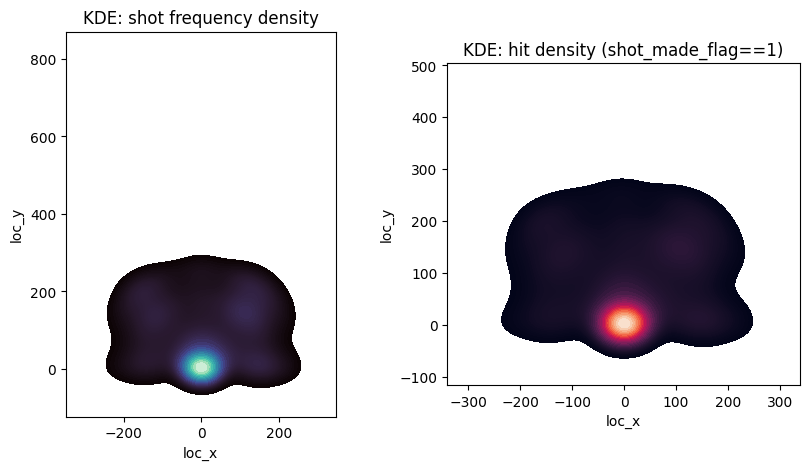

In [9]:
# Cell 2: KDE plots (shot frequency)
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
sns.kdeplot(x=df['loc_x'], y=df['loc_y'], fill=True, cmap='mako', bw_method=0.3, levels=50)
plt.title('KDE: shot frequency density')
plt.gca().set_aspect('equal', adjustable='box')

# If shot_made_flag exists, overlay hit KDE in the second panel
plt.subplot(1,2,2)
if df['shot_made_flag'].notna().sum() > 0:
    hits = df[df['shot_made_flag'] == 1]
    sns.kdeplot(x=hits['loc_x'], y=hits['loc_y'], fill=True, cmap='rocket', bw_method=0.3, levels=50)
    plt.title('KDE: hit density (shot_made_flag==1)')
else:
    plt.text(0.5,0.5, 'No shot_made_flag available', ha='center')
plt.gca().set_aspect('equal', adjustable='box')
plt.show()

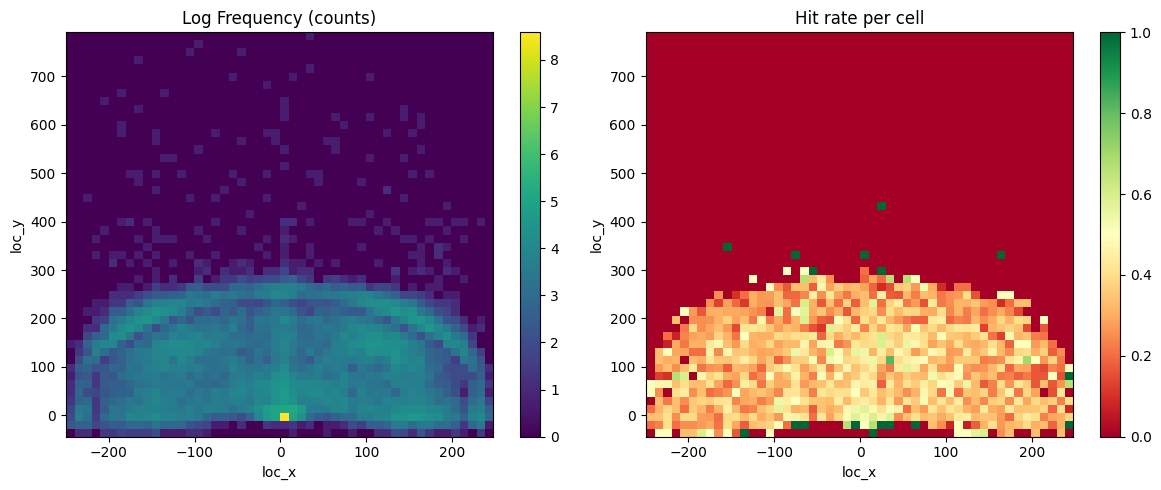

In [10]:
# Cell 3: grid-based frequency and hit-rate heatmaps
# Define grid resolution (adjustable)
nx, ny = 50, 50
x_min, x_max = df['loc_x'].min(), df['loc_x'].max()
y_min, y_max = df['loc_y'].min(), df['loc_y'].max()
x_bins = np.linspace(x_min, x_max, nx+1)
y_bins = np.linspace(y_min, y_max, ny+1)
# digitize to grid indices
ix = np.digitize(df['loc_x'], x_bins) - 1
iy = np.digitize(df['loc_y'], y_bins) - 1
# clamp indices
ix = np.clip(ix, 0, nx-1)
iy = np.clip(iy, 0, ny-1)
# accumulate counts and hits
counts = np.zeros((ny, nx), dtype=int)
hits = np.zeros((ny, nx), dtype=int)
for xii, yii, made in zip(ix, iy, df['shot_made_flag']):
    counts[yii, xii] += 1
    if pd.notnull(made) and made == 1:
        hits[yii, xii] += 1
# compute hit rate safely
hit_rate = np.zeros_like(counts, dtype=float)
mask = counts > 0
hit_rate[mask] = hits[mask] / counts[mask]

# plot frequency heatmap and hit-rate heatmap side by side
fig, axes = plt.subplots(1,2, figsize=(12,5))
im0 = axes[0].imshow(np.log1p(counts), origin='lower', cmap='viridis',
                     extent=(x_min, x_max, y_min, y_max), aspect='auto')
axes[0].set_title('Log Frequency (counts)')
fig.colorbar(im0, ax=axes[0])
# hit rate colormap: use a diverging palette but clip to [0,1]
im1 = axes[1].imshow(hit_rate, origin='lower', cmap='RdYlGn', vmin=0, vmax=1,
                   extent=(x_min, x_max, y_min, y_max), aspect='auto')
axes[1].set_title('Hit rate per cell')
fig.colorbar(im1, ax=axes[1])
for ax in axes:
    ax.set_xlabel('loc_x')
    ax.set_ylabel('loc_y')
plt.tight_layout()
plt.show()

## 2(b) Spatial Analysis

Spatial Preference Modeling: Fit Gaussian Mixture Models (GMMs) to cluster shot locations, identify high-efficiency hot zones, and calculate Expected Points per Shot (EPPS) as a spatial efficiency metric.


GMM: best n by BIC = 10


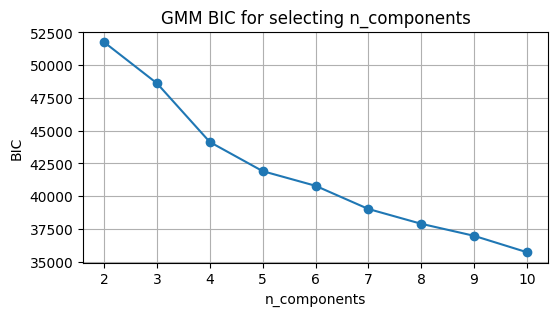

Cluster Statistics (sorted by EPPS descending):


,cluster,n_shots,hits,hit_rate,total_points,EPPS,mean_dist,center_x,center_y
0,3,5182,2696,0.520262,5392,1.040525,0.000000,6.670220e-13,8.697043e-12
1,0,2196,636,0.289617,1905,0.867486,258.215609,1.409074e+02,2.101472e+02
2,7,5027,2117,0.421126,4234,0.842252,52.524929,3.465780e+00,4.157520e+01
3,8,2016,547,0.271329,1636,0.811508,259.191173,-1.539156e+02,2.031500e+02
4,5,2313,775,0.335063,1809,0.782101,211.809933,-3.994954e+00,2.041106e+02
5,6,4763,1648,0.346000,3408,0.715515,181.854703,1.179065e+02,1.300149e+02
6,1,2351,795,0.338154,1661,0.706508,147.099205,-1.395307e+02,1.895511e+01
7,4,2936,988,0.336512,2070,0.705041,150.982540,1.454191e+02,1.420367e+01
8,2,3741,1258,0.336274,2582,0.690190,180.035072,-1.203985e+02,1.261951e+02
9,9,172,5,0.029070,15,0.087209,456.314840,6.879613e+00,3.638880e+02


Cluster assignments and cluster statistics have been saved to gmm_clusters.csv


In [11]:
# Stage 3: GMM Clustering and EPPS (Expected Points Per Shot) Evaluation
# This module will:
# 1) Perform clustering on shooting coordinates using GMM;
# 2) Select the optimal number of components from candidate cluster counts using BIC;
# 3) Calculate the number of makes, make rate, total points for each cluster, and compute EPPS = total points / number of shots in the cluster;
# 4) Visualize cluster centers colored by EPPS and save cluster assignments to CSV.

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import StandardScaler

# Load raw data (use original fields to access shot_type / shot_made_flag / shot_id)
# filename = "data.csv"
raw = pd.read_csv(filename)
df_gmm = raw.copy()
# Filter out records with missing coordinates
df_gmm = df_gmm[pd.notnull(df_gmm['loc_x']) & pd.notnull(df_gmm['loc_y'])].copy()
# Ensure target variable is numeric
df_gmm['shot_made_flag'] = pd.to_numeric(df_gmm['shot_made_flag'], errors='coerce')
# Infer points based on shot_type (simplified rule: treat as 3-pointer if '3' is included, otherwise 2-pointer)
if 'shot_type' in df_gmm.columns:
    df_gmm['points'] = np.where(df_gmm['shot_type'].astype(str).str.contains('3', na=False), 3, 2)
else:
    df_gmm['points'] = 2
# Calculate polar coordinate feature (if not already computed)
if 'dist' not in df_gmm.columns:
    df_gmm['dist'] = np.sqrt(df_gmm['loc_x']**2 + df_gmm['loc_y']**2)
# Extract coordinates for clustering
X = df_gmm[['loc_x', 'loc_y']].to_numpy()
# Standardize coordinates to ensure stable GMM performance (inverse transform back to original coordinates for visualization)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Select optimal number of components (n_components) — use BIC, search from 2 to 10 (adjustable)
n_components = range(2, 11)
bics = []
for n in n_components:
    gm = GaussianMixture(n_components=n, covariance_type='full', random_state=42)
    gm.fit(X_scaled)
    bics.append(gm.bic(X_scaled))
best_n = int(n_components[np.argmin(bics)])
print('GMM: best n by BIC =', best_n)
plt.figure(figsize=(6,3))
plt.plot(list(n_components), bics, marker='o')
plt.xlabel('n_components')
plt.ylabel('BIC')
plt.title('GMM BIC for selecting n_components')
plt.grid(True)
plt.show()

# Fit GMM with optimal components and assign cluster labels
gmm = GaussianMixture(n_components=best_n, covariance_type='full', random_state=42)
labels = gmm.fit_predict(X_scaled)
df_gmm['cluster'] = labels
# Cluster centers (inverse transform back to original coordinate system)
centers_scaled = gmm.means_
centers = scaler.inverse_transform(centers_scaled)

# Calculate statistics for each cluster: number of shots, number of makes, make rate, total points, EPPS (Expected Points Per Shot)
cluster_stats = []
for k in range(best_n):
    sub = df_gmm[df_gmm['cluster'] == k]
    n_shots = len(sub)
    hits = int(sub['shot_made_flag'].sum(skipna=True)) if n_shots > 0 else 0
    total_points = int(sub.loc[sub['shot_made_flag'] == 1, 'points'].sum()) if n_shots > 0 else 0
    ep_per_shot = (total_points / n_shots) if n_shots > 0 else np.nan
    hit_rate = (hits / n_shots) if n_shots > 0 else np.nan
    mean_dist = sub['dist'].mean() if 'dist' in sub.columns else np.nan
    cluster_stats.append({
        'cluster': int(k),
        'n_shots': int(n_shots),
        'hits': int(hits),
        'hit_rate': float(hit_rate) if not pd.isna(hit_rate) else np.nan,
        'total_points': int(total_points),
        'EPPS': float(ep_per_shot) if not pd.isna(ep_per_shot) else np.nan,
        'mean_dist': float(mean_dist) if not pd.isna(mean_dist) else np.nan,
        'center_x': float(centers[k,0]),
        'center_y': float(centers[k,1])
    })
clusters_df = pd.DataFrame(cluster_stats).sort_values('EPPS', ascending=False).reset_index(drop=True)
print('Cluster Statistics (sorted by EPPS descending):')
display(clusters_df)

# Merge cluster information back to original dataframe and save (for subsequent analysis)
out = df_gmm[['shot_id', 'loc_x', 'loc_y', 'cluster', 'shot_made_flag', 'points']].copy() if 'shot_id' in df_gmm.columns else df_gmm[['loc_x','loc_y','cluster','shot_made_flag','points']].copy()
# Merge cluster-level statistics
out = out.merge(clusters_df[['cluster','n_shots','hit_rate','EPPS']], on='cluster', how='left')
out.to_csv('gmm_clusters.csv', index=False)
print('Cluster assignments and cluster statistics have been saved to gmm_clusters.csv')

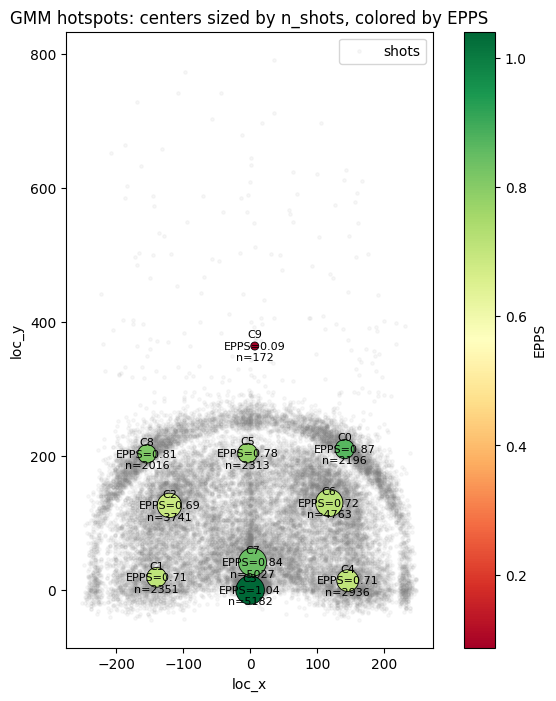

In [12]:
# Visualization: Scatter plot (all shots in gray), cluster centers colored by EPPS and sized by sample count
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 8))
# Plot all shooting positions with low transparency
plt.scatter(df_gmm['loc_x'], df_gmm['loc_y'], s=6, alpha=0.06, color='gray', label='shots')
# Plot cluster centers
sizes = (clusters_df['n_shots'] / clusters_df['n_shots'].max()) * 400 + 20
sc = plt.scatter(clusters_df['center_x'], clusters_df['center_y'], s=sizes, c=clusters_df['EPPS'], cmap='RdYlGn', edgecolors='k', linewidths=0.6)
for _, r in clusters_df.iterrows():
    txt = f"C{int(r['cluster'])}\nEPPS={r['EPPS']:.2f}\nn={int(r['n_shots'])}"
    plt.text(r['center_x'], r['center_y'], txt, ha='center', va='center', fontsize=8)
plt.colorbar(sc, label='EPPS')
plt.xlabel('loc_x')
plt.ylabel('loc_y')
plt.title('GMM hotspots: centers sized by n_shots, colored by EPPS')
plt.gca().set_aspect('equal', adjustable='box')
plt.legend(loc='upper right')
plt.show()

In [13]:
# Optional: Export detailed cluster table to CSV (cluster sorting is already applied in clusters_df)
clusters_df.to_csv('gmm_cluster_summary.csv', index=False)
print('Cluster summary saved to gmm_cluster_summary.csv')
# Display top / bottom clusters for quick inspection
display(clusters_df.head())
display(clusters_df.tail())

Cluster summary saved to gmm_cluster_summary.csv


,cluster,n_shots,hits,hit_rate,total_points,EPPS,mean_dist,center_x,center_y
0,3,5182,2696,0.520262,5392,1.040525,0.000000,6.670220e-13,8.697043e-12
1,0,2196,636,0.289617,1905,0.867486,258.215609,1.409074e+02,2.101472e+02
2,7,5027,2117,0.421126,4234,0.842252,52.524929,3.465780e+00,4.157520e+01
3,8,2016,547,0.271329,1636,0.811508,259.191173,-1.539156e+02,2.031500e+02
4,5,2313,775,0.335063,1809,0.782101,211.809933,-3.994954e+00,2.041106e+02


,cluster,n_shots,hits,hit_rate,total_points,EPPS,mean_dist,center_x,center_y
5,6,4763,1648,0.346000,3408,0.715515,181.854703,117.906495,130.014931
6,1,2351,795,0.338154,1661,0.706508,147.099205,-139.530737,18.955113
7,4,2936,988,0.336512,2070,0.705041,150.982540,145.419059,14.203666
8,2,3741,1258,0.336274,2582,0.690190,180.035072,-120.398469,126.195140
9,9,172,5,0.029070,15,0.087209,456.314840,6.879613,363.888044


## 2(c) Temporal and Pressure Analysis

Temporal and Pressure Analysis: Use Generalized Additive Models (GAMs) or Spline regression to model nonlinear effects of remaining time on shot accuracy. Test interactions between score differential and accuracy, and examine clutch-time effects (last two minutes, score difference ≤ 5 points).


In [14]:
# Specific tasks include:
# - Check and prompt for pygam installation (for GAM);
# - Prepare data: remaining_time, dist, shot_made_flag;
# - Train LogisticGAM (smoothing splines) and plot partial dependence plots;
# - Test the difference between make rate and model prediction probability in the clutch subset (last 2 minutes, score difference <= 5 points).

Dependencies and Environment Check (If pygam is not installed, run pip install pygam first)

The cell below will attempt to import pygam; if it is not installed, the installation command will be printed.


In [15]:
# Cell: environment check and data preparation for GAM
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler

# try import pygam and give install instructions if missing
has_pygam = True
try:
    from pygam import LogisticGAM, s, te
except Exception as e:
    has_pygam = False
    print('pygam not installed. Install with: pip install pygam')

# load data (use data.csv as in other cells)
# filename = "data.csv"
raw = pd.read_csv(filename)
df_g = raw.copy()
# ensure shot_made_flag present and numeric; filter train rows
if 'shot_made_flag' not in df_g.columns:
    raise ValueError('Missing shot_made_flag column in data, cannot perform supervised learning analysis')
df_g['shot_made_flag'] = pd.to_numeric(df_g['shot_made_flag'], errors='coerce')
df_g = df_g[pd.notnull(df_g['shot_made_flag'])].copy()
# remaining_time (compute if missing)
if 'remaining_time' not in df_g.columns:
    if 'minutes_remaining' in df_g.columns and 'seconds_remaining' in df_g.columns:
        df_g['remaining_time'] = df_g['minutes_remaining'] * 60 + df_g['seconds_remaining']
    else:
        df_g['remaining_time'] = np.nan
# dist (compute if missing)
if 'dist' not in df_g.columns and 'loc_x' in df_g.columns and 'loc_y' in df_g.columns:
    df_g['dist'] = np.sqrt(df_g['loc_x']**2 + df_g['loc_y']**2)
# attempt to get score margin if available (common field names)
score_cols = ['score_margin', 'score_diff', 'score_difference', 'margin', 'score_margin_home']
score_col_found = None
for c in score_cols:
    if c in df_g.columns:
        score_col_found = c
        break
if score_col_found is not None:
    df_g['score_margin'] = pd.to_numeric(df_g[score_col_found], errors='coerce')
    print('Found score margin column:', score_col_found)
else:
    # try to parse home/away scores if present (home_score/away_score or visitor/home) - not guaranteed
    df_g['score_margin'] = np.nan
    print('No explicit score margin column found; interaction tests will be skipped unless you provide a score_margin column.')

# drop rows missing required continuous features
required = ['remaining_time', 'dist']
missing_req = df_g[required].isnull().any(axis=1)
n_missing = missing_req.sum()
if n_missing > 0:
    print(f'Removing {n_missing} rows missing remaining_time or dist')
    df_g = df_g[~missing_req].copy()

print('Prepared GAM dataset rows:', len(df_g))
# features matrix and target
X_raw = df_g[['remaining_time', 'dist']].to_numpy()
y = df_g['shot_made_flag'].astype(int).to_numpy()
# scale features
scaler = StandardScaler()
X = scaler.fit_transform(X_raw)

# place useful objects into globals for following cells
globals().update({'df_gam': df_g, 'X_gam': X, 'y_gam': y, 'has_pygam': has_pygam, 'scaler_gam': scaler})
print('Ready: df_gam, X_gam, y_gam, has_pygam available')

No explicit score margin column found; interaction tests will be skipped unless you provide a score_margin column.
Prepared GAM dataset rows: 25697
Ready: df_gam, X_gam, y_gam, has_pygam available


  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--


Performing gridsearch (may take a bit)...


  9% (1 of 11) |##                       | Elapsed Time: 0:00:01 ETA:   0:00:18
 18% (2 of 11) |####                     | Elapsed Time: 0:00:02 ETA:   0:00:11
 27% (3 of 11) |######                   | Elapsed Time: 0:00:03 ETA:   0:00:08
 36% (4 of 11) |#########                | Elapsed Time: 0:00:03 ETA:   0:00:06
 45% (5 of 11) |###########              | Elapsed Time: 0:00:04 ETA:   0:00:05
 54% (6 of 11) |#############            | Elapsed Time: 0:00:05 ETA:   0:00:04
 63% (7 of 11) |###############          | Elapsed Time: 0:00:05 ETA:   0:00:03
 72% (8 of 11) |##################       | Elapsed Time: 0:00:06 ETA:   0:00:02
 81% (9 of 11) |####################     | Elapsed Time: 0:00:07 ETA:   0:00:01
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:07 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:08 Time:  0:00:08
C:\Users\fh\AppData\Local\Temp\ipykernel_32836\3812703818.py:10: UserWarning: KNOWN BUG: p-values computed in this summa

LogisticGAM                                                                                               
=============================================== ==========================================================
Distribution:                      BinomialDist Effective DoF:                                     36.2148
Link Function:                        LogitLink Log Likelihood:                                -16980.7538
Number of Samples:                        25697 AIC:                                            34033.9371
                                                AICc:                                           34034.0479
                                                UBRE:                                               3.3256
                                                Scale:                                                 1.0
                                                Pseudo R-Squared:                                   0.0386
Feature Function                  Lam

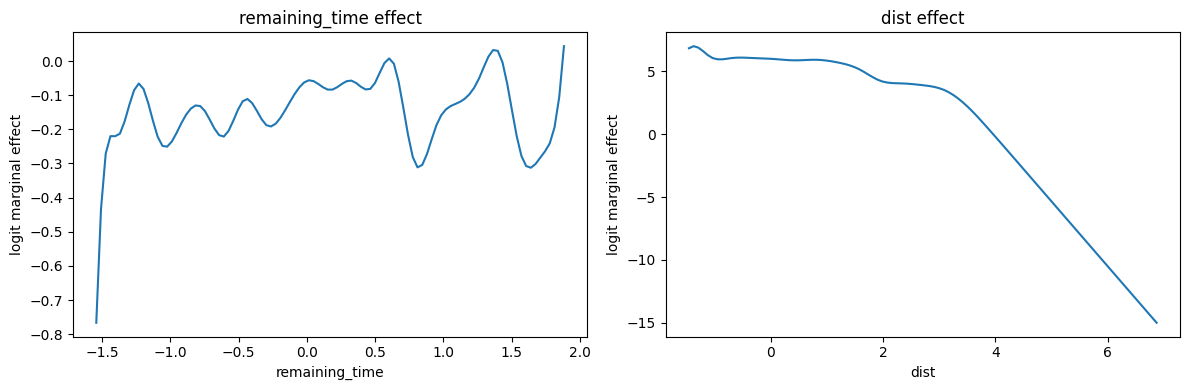

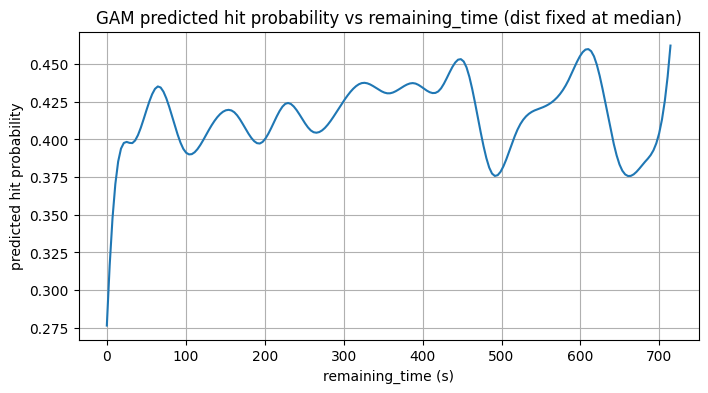

In [16]:
# Cell: Fit LogisticGAM (smoothing splines) and plot partial dependence
if not globals().get('has_pygam', False):
    print('pygam is not installed — cannot train GAM. Please run: pip install pygam')
else:
    from pygam import LogisticGAM, s, te
    # Build base model: smooth over remaining_time and dist
    gam = LogisticGAM(s(0, n_splines=25) + s(1, n_splines=25), verbose=False)
    print('Performing gridsearch (may take a bit)...')
    gam.gridsearch(globals()['X_gam'], globals()['y_gam'])
    print(gam.summary())
    # Partial dependence plots for each smooth term
    fig, axs = plt.subplots(1,2, figsize=(12,4))
    titles = ['remaining_time effect', 'dist effect']
    for i, ax in enumerate(axs):
        XX = gam.generate_X_grid(term=i)
        pdep = gam.partial_dependence(term=i, X=XX)
        ax.plot(XX[:, i], pdep)
        ax.set_title(titles[i])
        ax.set_xlabel(['remaining_time','dist'][i])
        ax.set_ylabel('logit marginal effect')
    plt.tight_layout()
    plt.show()

    # For visualization: predicted probability vs remaining_time (keep dist at median)
    med_dist = np.median(globals()['X_gam'][:,1])
    grid_rt = np.linspace(globals()['X_gam'][:,0].min(), globals()['X_gam'][:,0].max(), 200)
    XX = np.column_stack([grid_rt, np.full_like(grid_rt, med_dist)])
    # get predictions in a robust way (pygam may return 1D or 2D arrays)
    if hasattr(gam, 'predict_mu'):
        preds = gam.predict_mu(XX)
    else:
        preds = gam.predict_proba(XX)
    preds = np.asarray(preds)
    if preds.ndim == 2 and preds.shape[1] > 1:
        # if predict_proba returned [[p0,p1],...], take probability of positive class if present
        probs = preds[:, -1]
    else:
        # otherwise flatten to 1D
        probs = preds.ravel()
    # inverse transform X grid to original remaining_time scale for plotting
    inv = globals()['scaler_gam'].inverse_transform(XX)[:,0]
    plt.figure(figsize=(8,4))
    plt.plot(inv, probs)
    plt.xlabel('remaining_time (s)')
    plt.ylabel('predicted hit probability')
    plt.title('GAM predicted hit probability vs remaining_time (dist fixed at median)')
    plt.grid(True)
    plt.show()

Empirical hit rates (last 2 minutes vs others):


,emp_hit_rate,count
last_2_min,,
False,0.456615,20122
True,0.408430,5575


Model predicted mean probabilities by last_2_min:


,model_pred_prob,count
last_2_min,,
False,0.456772,20122
True,0.407862,5575


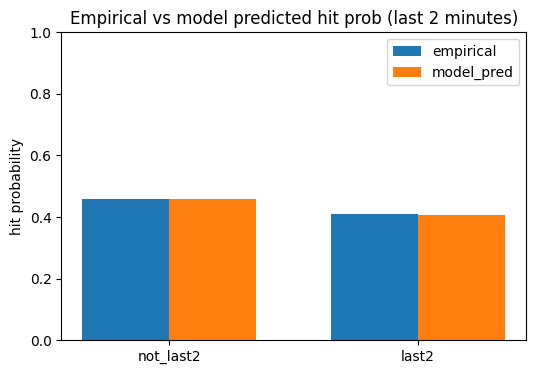

In [17]:
# Cell: Key-moment subgroup analysis (last 2 minutes, close game (<=5 pts))
df = globals().get('df_gam')
if df is None:
    raise RuntimeError('df_gam not found — run preparation cell first')
# create pressure indicators
df['last_2_min'] = df['remaining_time'] <= 120
if 'score_margin' in df.columns and df['score_margin'].notna().any():
    df['close_game'] = df['score_margin'].abs() <= 5
else:
    df['close_game'] = False

# empirical rates
grp = df.groupby('last_2_min')['shot_made_flag'].agg(['mean','count']).rename(columns={'mean':'emp_hit_rate'})
print('Empirical hit rates (last 2 minutes vs others):')
display(grp)

# model predicted probabilities for groups (if GAM exists)
if globals().get('has_pygam', False):
    gam = locals().get('gam', globals().get('gam'))
    if gam is not None:
        # predict for each row and compare mean predicted prob per subgroup
        Xg = globals().get('X_gam')
        # pygam's predict methods may return 1D or 2D arrays; handle both safely
        if hasattr(gam, 'predict_proba'):
            raw_preds = gam.predict_proba(Xg)
        else:
            raw_preds = gam.predict_mu(Xg)
        raw_preds = np.asarray(raw_preds)
        if raw_preds.ndim == 2 and raw_preds.shape[1] > 1:
            preds = raw_preds[:, -1]  # take positive-class probability if present
        else:
            preds = raw_preds.ravel()
        df['pred_prob'] = preds
        model_grp = df.groupby('last_2_min')['pred_prob'].agg(['mean','count']).rename(columns={'mean':'model_pred_prob'})
        print('Model predicted mean probabilities by last_2_min:')
        display(model_grp)
        # close game comparison if available
        if df['close_game'].any():
            print('Close game empirical rates:')
            display(df.groupby('close_game')['shot_made_flag'].agg(['mean','count']).rename(columns={'mean':'emp_hit_rate'}))
            print('Close game model predicted probs:')
            display(df.groupby('close_game')['pred_prob'].agg(['mean','count']).rename(columns={'mean':'model_pred_prob'}))
else:
    print('GAM is not trained or unavailable; skipping model prediction comparison.')

# Visual: side-by-side bar chart of empirical vs predicted for last_2_min
import matplotlib.pyplot as plt
emp = df.groupby('last_2_min')['shot_made_flag'].mean()
predm = df.groupby('last_2_min')['pred_prob'].mean() if 'pred_prob' in df.columns else None
labels = ['not_last2','last2']
x = np.arange(len(labels))
width = 0.35
plt.figure(figsize=(6,4))
plt.bar(x - width/2, [emp.get(False, np.nan), emp.get(True, np.nan)], width, label='empirical')
if predm is not None:
    plt.bar(x + width/2, [predm.get(False, np.nan), predm.get(True, np.nan)], width, label='model_pred')
plt.xticks(x, labels)
plt.ylabel('hit probability')
plt.title('Empirical vs model predicted hit prob (last 2 minutes)')
plt.legend()
plt.ylim(0,1)
plt.show()

# Conclusion of the Research Process

## 1. Comprehensive Variable Design with High Alignment to Practical Scenarios

The design of derived variables is highly precise, particularly the "psychological pressure proxy variables" (remaining time < 24 seconds, shots taken when trailing) and "game context variables" (point difference, home/away games). This approach goes beyond pure data dimensions and integrates real basketball game scenarios (e.g., pressure in critical moments), making the analysis conclusions more valuable for tactical reference.

## 2. Method Selection Highly Matched to Research Objectives

The research methods are strategically chosen to directly address the core research goals, ensuring both depth and accuracy of analysis:

- The combination of **Kernel Density Estimation (KDE) ** not only solves the visualization problem of "where shots are taken most frequently" but also verifies "whether clusters are statistically significant" through spatial autocorrelation testing, avoiding subjective biases of heatmaps.
- Using **Gaussian Mixture Model (GMM) clustering** to identify shooting hot zones is more flexible than traditional "fixed area division" (e.g., restricted area/three-point line). It can uncover Kobe’s truly personalized advantageous areas (such as mid-range shots at a specific angle).
